In [47]:
import numpy as np
import pandas as pd
from graphviz import Digraph
import copy

%matplotlib inline

# CART regression trees

Regression trees define regions in the feature space $X$ and assign them a constant value $c$. This value is the prediction of all examples that fall into that region. Consider the following drawing:

![](img/split.png)

We want to predict a value y based on two features, $x_1$ and $x_2$ that build our feature space $X$. The whole space is now split twice and the resulting regions $R_1$, $R_2$, $R_3$ and $R_4$ each get a constant value assigned. This value is chosen by calculating the average of all target values in the region, since this minimizes the sum of squares error for that region.

Binary splits are used as partition mechanism where splitting a region always results in two new regions. When a value is less than or equal to a found threshold, it is assigned to the first region, all other values are assigned to the second region. Resulting regions are split recursively until a certain stop condition, e.g. a maximum number of splits or a minimum number of samples per region is reached.

But how do we find the thresholds? ESL concludes that it is infeasible to find an optimal solution within all possible splits. Thus, a greedy search is used:
Look for each feature variable $x_n$ for the split that minimizes the sum of squared errors and afterwards look for the variable $x_n$ with the smallest resulting sum of squared errors. This variable and threshold combination is used for the split, resulting in two new regions.

This notebook displays an implementation of CART regression trees. It is in no way optimized for performance and should only help in understanding the basic principles of regression trees.

### Regions and region splits

The basic building block of CART regression trees is the Region. We define a Region as a set of samples that is split into feature space $X$ and target values $y$. The number of samples in the Region is its $size$ and the predicted value for this region, called $c$, is the average of all target values:

```python
class Region(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = self.X.shape[0]
        self.c = np.mean(y) if self.size > 0 else 0
```
   
Next, we want to be able to split a region, based on a variable and a splitting point.

```python
    def partition(self, j, s):
            X, y = self.X, self.y
            split = X[:, j] <= s
            X1, X2 = X[split], X[~split]
            y1, y2 = y[split], y[~split]
            return Region(X1, y1), Region(X2, y2)
```

$j$ is the index of the variable we want to split on and $s$ the splitting point. Two new regions are returned. This enables us to create more specific regions and in turn better predictions.

As described above, greedy search is used to find the splitting variable and splitting point. For this, we need to define the cost of a split, in order to look for the split with minimal costs (at least in this local setting):

```python
# not part of the Region class
def splitting_cost(y1, y2, c1, c2):
    return np.sum(np.square(y1 - c1)) + np.sum(np.square(y2 - c2))
```

The splitting cost as defined in ESL section 9.2.2 (9.13) are the sum of squares of differences between target values and their mean (i.e. the prediction value of that region) of both created regions. Now we can choose the best splitting point for a variable based on the associated costs:

```python
    def _choose_per_variable(self, j):
        X, y = self.X, self.y
        possible_values = np.unique(X[:, j])
        s_hat, cost_hat = None, np.Inf
        for s in possible_values:
            r1, r2 = self.partition(j, s)
            cost = splitting_cost(r1.y, r2.y, r1.c, r2.c)
            if cost < cost_hat:
                s_hat = s
                cost_hat = cost
        return s_hat, cost_hat
```

A variable j (index based) is selected and all values of that variable available in the region are candidates for the best splitting point. For each candidate, the splitting costs are computed. The splitting point with the lowest costs is returned - along the these costs.

Now we can do this for all available variables:

```python
    def choose_overall(self):
        X, y = self.X, self.y
        possible_variables = np.arange(0, X.shape[1], 1)
        j_hat, s_hat, cost_hat = None, None, np.Inf
        for j in possible_variables:
            s, cost = self._choose_per_variable(j)
            if cost < cost_hat:
                j_hat = j
                s_hat = s
                cost_hat = cost
        return j_hat, s_hat
```

In the end, the variable and splitting point combination with the lowest costs (for this specific region) defines the next split. As said, this is a greedy approach as it only considers the individual region and does not try to solve multiple splits at once. 

Here is the complete code:

In [48]:
def splitting_cost(y1, y2, c1, c2):
    return np.sum(np.square(y1 - c1)) + np.sum(np.square(y2 - c2))

In [49]:
class Region(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = self.X.shape[0]
        self.c = np.mean(y) if self.size > 0 else 0
    
    def partition(self, j, s):
        """
        j: splitting variable position (starting with 0)
        s: splitting point
        
        """
        X, y = self.X, self.y
        split = X[:, j] <= s
        X1, X2 = X[split], X[~split]
        y1, y2 = y[split], y[~split]
        return Region(X1, y1), Region(X2, y2)
    
    def _choose_per_variable(self, j):
        X, y = self.X, self.y
        possible_values = np.unique(X[:, j])
        s_hat, cost_hat = None, np.Inf
        for s in possible_values:
            r1, r2 = self.partition(j, s)
            cost = splitting_cost(r1.y, r2.y, r1.c, r2.c)
            if cost < cost_hat:
                s_hat = s
                cost_hat = cost
        return s_hat, cost_hat
    
    def choose_overall(self):
        X, y = self.X, self.y
        possible_variables = np.arange(0, X.shape[1], 1)
        j_hat, s_hat, cost_hat = None, None, np.Inf
        for j in possible_variables:
            s, cost = self._choose_per_variable(j)
            if cost < cost_hat:
                j_hat = j
                s_hat = s
                cost_hat = cost
        return j_hat, s_hat

### Nodes and trees

Nodes are an additional abstraction layer to put regions into a descision tree. Each node represents a branching point or leaf in the overall decision tree.

```python
class Node(object):
    def __init__(self, parent, r, is_left):
        self.parent = parent
        self.r = r
        self.is_left = is_left
        self.j = None
        self.s = None
        self.left_child = None
        self.right_child = None
```

A node gets three parameters: The parent node (None if it is the root node), the associated region and whether it is the left node (again None for the root node). In addition, it stores four variables that are only relevant for branching nodes: The splitting variable, splitting point, the left child and the right child. These variables are updated during the children setup, which uses the region splitting that was explained in the last section:

```python
    def setup_children(self, min_node_size):
        self.j, self.s = self.r.choose_overall()
        r1, r2 = self.r.partition(self.j, self.s)
        if r1.size >= min_node_size and r2.size >= min_node_size:
            self.left_child = Node(self, r1, True)
            self.right_child = Node(self, r2, False)
        return self.left_child, self.right_child
```

The function requires a minimum node size. Thus, after splitting it is checked whether both nodes still have regions that have more samples than the minimum node size. If this is the case, two new nodes are created and assigned as children. Else this node turns into a leaf or terminal node.

The children setup is triggered by the Tree. The Tree is the overall structure that combines multiple nodes.

```python
class Tree(object):
    def __init__(self, min_node_size):
        self.min_node_size = min_node_size
        self.nodes = []
        self._terminal_nodes = None
```

It receives a single parameter, the minimum node size we already saw for the setup_children function. It stores all nodes and has a separate pointer to all terminal_nodes. In order to build the tree - and with that populate the nodes and terminal_nodes lists - we use a fit function, to kind of conform to the well known scikit-learn estimator API:

```python
    def fit(self, X, y):
        self.nodes = self.build_tree(X, y, self.min_node_size)
```

The fit function does not do much, so next up is the build_tree function:

```python
    @staticmethod
    def build_tree(X, y, min_node_size):
        root = Node(None, Region(X, y), None)
        to_be_processed = [root]
        def build_tree_helper(ls, accu):
            if len(ls) == 0:
                return accu
            else:
                head, tail = ls.pop(0), ls
                t1, t2 = head.setup_children(min_node_size)
                accu.append(head)
                if t1 is not None:
                    tail += [t1, t2]
                return build_tree_helper(tail, accu)
        return build_tree_helper(to_be_processed, [])
```

First, a root node is created and added to a list of nodes that still need to be processed. Now we pass this list into an end recursive function that is going to create all nodes of this tree until the minimum node size is reached for all nodes. This is done by adding all newly created nodes to the to-be-processed list and removing already processed nodes from it.

Fitting is all good, but in the end we are interested in predicting, so let's look at the predict function (again like scikit-learn):

```python
    def predict(self, X):
        return np.apply_along_axis(self.predict_single_sample, 1, X)

    def predict_single_sample(self, x):
        root = self.nodes[0]
        current_node = root
        while not current_node.is_terminal():
            if x[current_node.j] <= current_node.s:
                current_node = current_node.left_child
            else:
                current_node = current_node.right_child
        return current_node.r.c
```

The function starts at the root node and goes down the tree according to the splitting variables and splitting points until a terminal node is hit. It then returns the constant prediction $c$ of that terminal node. In order to identify terminal nodes, the following function is used:

```python
class Node(object):
    #...
    def is_terminal(self):
        return self.left_child is None
    #...
```

In [50]:
class Node(object):
    def __init__(self, parent, r, is_left):
        """parent, left_child and right_child are nodes"""
        self.parent = parent
        self.r = r
        self.is_left = is_left
        self.j = None
        self.s = None
        self.left_child = None
        self.right_child = None
        
    def __repr__(self):
        return "Node: (%s, %s) - %d" % (self.j, self.s, self.r.size)
    
    def __str__(self):
        return "Node: (%s, %s) - %d" % (self.j, self.s, self.r.size)
        
    def setup_children(self, min_node_size):
        self.j, self.s = self.r.choose_overall()
        r1, r2 = self.r.partition(self.j, self.s)
        if r1.size >= min_node_size and r2.size >= min_node_size:
            self.left_child = Node(self, r1, True)
            self.right_child = Node(self, r2, False)
        return self.left_child, self.right_child
    
    def to_string(self):
        return "%0.4f (%s)" % (self.r.c, self.r.size) if self.is_terminal() else "X[%s] <= %0.4f" % (self.j, self.s)
        
    def is_terminal(self):
        return self.left_child is None
    
    def is_root(self):
        return self.parent is None
            
    def cost_complexity(self):
        N_m = self.r.size
        c_m = self.r.c
        return np.sum(np.square(self.r.y - [c_m])) / N_m
    
    def get_all_deep_children(self):
        def deep_helper(to_be_processed, accu):
            if len(to_be_processed) == 0:
                return accu
            else:
                head, tail = to_be_processed.pop(0), to_be_processed
                children = []
                if not head.is_terminal():
                    children = [head.left_child, head.right_child]
                return deep_helper(tail + children, accu + [head])
        return deep_helper([self], [])

In [51]:
class Tree(object):
    def __init__(self, min_node_size):
        self.min_node_size = min_node_size
        self.nodes = []
        self._terminal_nodes = None
        
    def fit(self, X, y):
        self.nodes = self.build_tree(X, y, self.min_node_size)
        
    @staticmethod
    def build_tree(X, y, min_node_size):
        root = Node(None, Region(X, y), None)
        to_be_processed = [root]
        def build_tree_helper(ls, accu):
            if len(ls) == 0:
                return accu
            else:
                head, tail = ls.pop(0), ls
                t1, t2 = head.setup_children(min_node_size)
                accu.append(head)
                if t1 is not None:
                    tail += [t1, t2]
                return build_tree_helper(tail, accu)
        return build_tree_helper(to_be_processed, [])
    
    @property
    def terminal_nodes(self):
        if self._terminal_nodes is None:
            self._terminal_nodes = filter(lambda x: x.is_terminal(), self.nodes)
        return self._terminal_nodes
        
    def predict(self, X):
        return np.apply_along_axis(self.predict_single_sample, 1, X)
    
    def predict_single_sample(self, x):
        root = self.nodes[0]
        current_node = root
        while not current_node.is_terminal():
            if x[current_node.j] <= current_node.s:
                current_node = current_node.left_child
            else:
                current_node = current_node.right_child
        return current_node.r.c
    
    def cost_complexity(self, alpha=0.0):
        return np.sum([t.cost_complexity() * t.r.size for t in self.terminal_nodes]) + alpha * len(self.terminal_nodes)
    
    def collapse(self, id):
        new_nodes = copy.deepcopy(self.nodes)
        root = new_nodes[0]
        new_nodes[id].left_child = None
        new_nodes[id].right_child = None
        tree_nodes = root.get_all_deep_children()
        tree = Tree(self.min_node_size)
        tree.nodes = tree_nodes
        return tree
    
    def to_graphviz(self):
        g = Digraph()
        for n in self.nodes:
            if not n.is_terminal():
                g.edge(n.to_string(), n.left_child.to_string())
                g.edge(n.to_string(), n.right_child.to_string())
                
        return g

In [52]:
from sklearn.datasets import load_boston
boston = load_boston()

In [53]:
X = boston["data"]
y = boston["target"]

In [54]:
tree = Tree(5)

In [55]:
tree.fit(X, y)

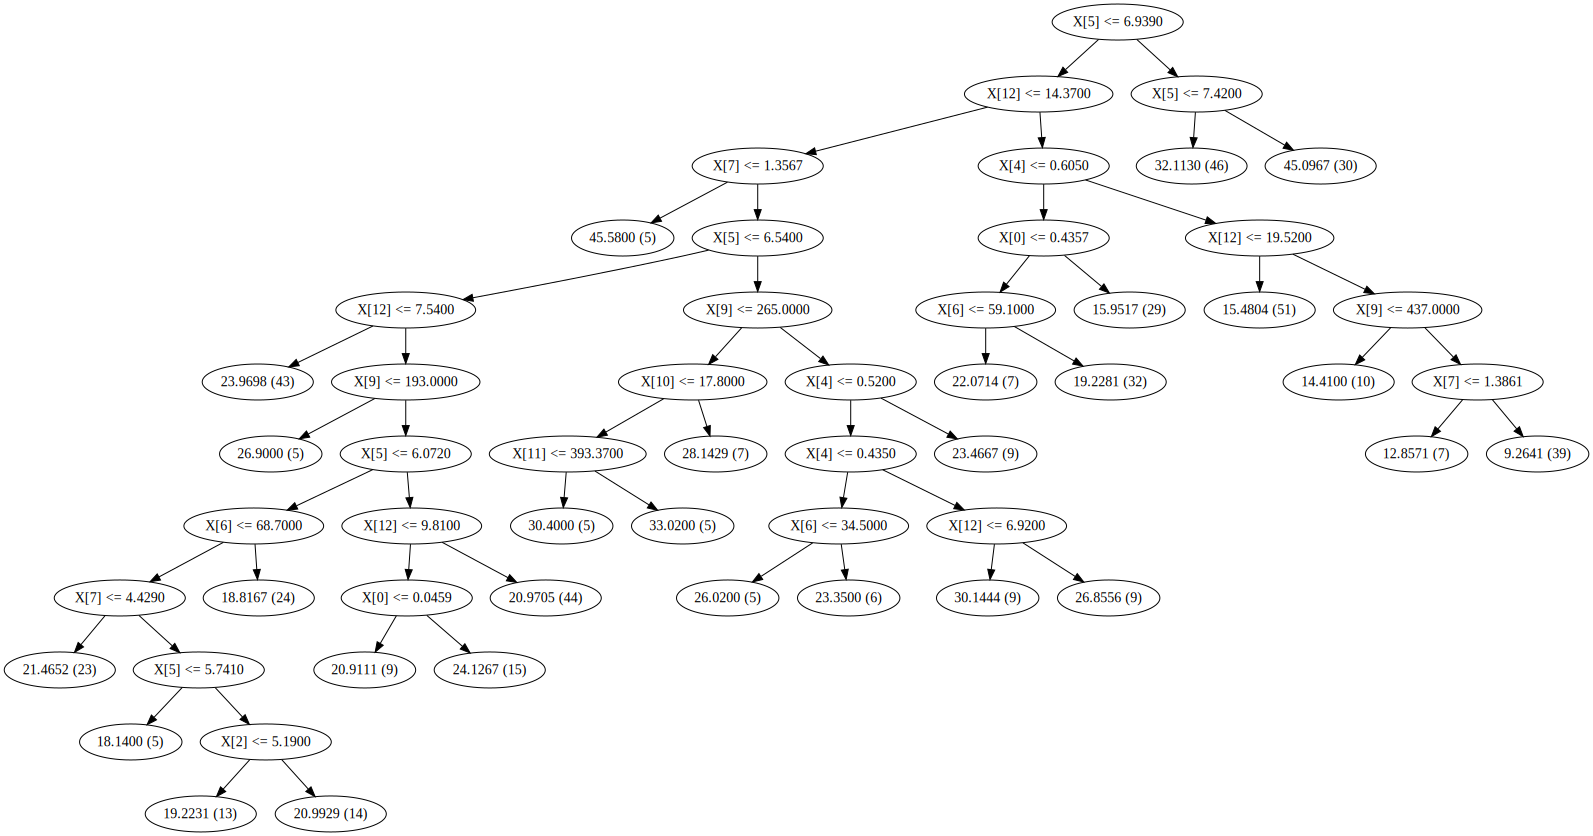

In [56]:
tree.to_graphviz()

In [57]:
def find_weakest_link(tree, alpha):
    original_cost = tree.cost_complexity(0)
    best_tree = None
    min_cost_inc = np.inf
    best_i = None
    for i in range(1, len(tree.nodes)):
        if not tree.nodes[i].is_terminal():
            new_tree = tree.collapse(i)
            new_cost = new_tree.cost_complexity(alpha)
            cost_inc = new_cost - original_cost
            cost_return = tree.cost_complexity(alpha)
            if cost_inc < min_cost_inc:
                best_tree = new_tree
                best_i = i
                min_cost_inc = cost_inc
                cost_return = new_tree.cost_complexity(alpha)
    return best_tree, best_i, cost_return

In [58]:
def weakest_link_pruning(tree, alpha):
    def pruning_helper(tree, accu):
        if len(tree.nodes) == 3:
            return accu
        else:
            t, i, c = find_weakest_link(tree, alpha)
            return pruning_helper(t, accu + [(t, c)])
    
    baseline = tree.cost_complexity(alpha)
    possible_improvement = pruning_helper(tree, [])
    best_cost = baseline
    best_tree = tree
    for t, c in possible_improvement:
        if c < baseline:
            best_tree = t
            best_cost = c
    return best_tree, best_cost

In [59]:
alpha = 50

In [60]:
pruned_tree, best_cost = weakest_link_pruning(tree, alpha)

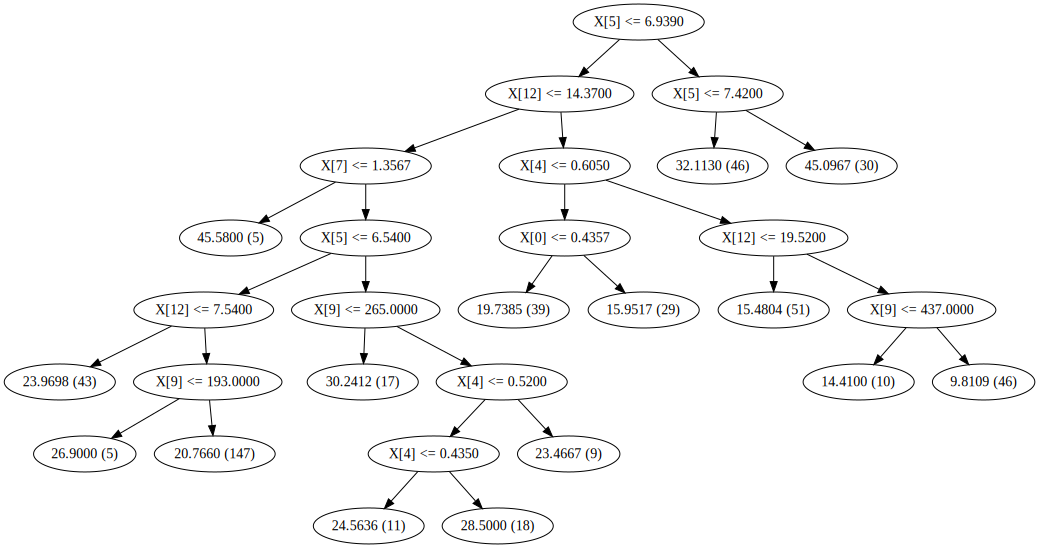

In [61]:
pruned_tree.to_graphviz()

In [62]:
print tree.cost_complexity(0)
print pruned_tree.cost_complexity(0)
print tree.cost_complexity(alpha)
print pruned_tree.cost_complexity(alpha)

5414.720474181908
6015.475780102627
6814.720474181908
6765.475780102627


In [63]:
y_hat = pruned_tree.predict(X)

In [64]:
np.mean(np.abs(y - y_hat) / y)

0.12087294551199852

In [65]:
from sklearn.model_selection import KFold

In [66]:
cv = KFold(n_splits=10)

In [67]:
for alpha in [13, 15, 17]:
    sum_of_squares = []
    for train_index, test_index in cv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        tree = Tree(3)
        tree.fit(X_train, y_train)
        pruned_tree, best_cost = weakest_link_pruning(tree, alpha)
        yhat = pruned_tree.predict(X_test)
        sum_of_squares.append(np.sum(np.square(yhat - y_test)))
    print "alpha= %s: sum of squares of %s" % (alpha, np.mean(sum_of_squares))

alpha= 13: sum of squares of 1675.251268314419
alpha= 15: sum of squares of 1655.8591775969483
alpha= 17: sum of squares of 1662.1979172294457


In [68]:
from sklearn.tree import DecisionTreeRegressor

In [69]:
for min_samples_split in [2, 5, 10, 15, 30, 50]:
    sum_of_squares = []
    for train_index, test_index in cv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        tree = DecisionTreeRegressor(min_samples_leaf=min_samples_split)
        tree.fit(X_train, y_train)
        yhat = tree.predict(X_test)
        sum_of_squares.append(np.sum(np.square(yhat - y_test)))
    print "depth= %s: sum of squares of %s" % (min_samples_split, np.mean(sum_of_squares))

depth= 2: sum of squares of 1899.568083333333
depth= 5: sum of squares of 1792.167539075806
depth= 10: sum of squares of 1355.0372085788902
depth= 15: sum of squares of 1453.309143420627
depth= 30: sum of squares of 1730.9810165487438
depth= 50: sum of squares of 1927.2275477351661
